In [1]:
import os
import torch
import pandas as pd
from time import time
from math import ceil
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from random import shuffle
#from tokenizers.pre_tokenizers import Whitespace

import matplotlib
import matplotlib.pyplot as plt
from numpy import linspace, interp

In [2]:
EPOCHS = 16
LR = 5.0
BATCH_SIZE = 16
WEIGHT_DECAY = 0
DROP_OUT = 0.3
PATIENCE = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
class HateSpeechDataset(Dataset):
    def __init__(self, contents):
        super(HateSpeechDataset, self).__init__()
        self.contents = contents
        self.nClasses = 3

    def __getitem__(self, index):
        return self.contents[index]
    
    def __len__(self):
        return len(self.contents)

In [4]:
def holdout(data_list, all_path, train_path, test_path):
    head = len(all_path) + 1
    tail = -len('.txt')

    try:
        training = [f[:tail] for f in os.listdir(train_path)]
    except:
        training = []
    try:
        testing = [f[:tail] for f in os.listdir(test_path)]
    except:
        testing = []

    remaining = [f[head:tail] for f in data_list if f[head:tail] not in training and f[head:tail] not in testing]
    partition = int(ceil(0.7 * len(remaining)))
    training = training + remaining[:partition]
    testing = testing + remaining[partition:]
    
    return training, testing

def build(data, path, train, test):
    train_entries = []
    test_entries = []
    numericise_labels = lambda l: 2 if l == 'hate' else 1 if l == 'relation' else 0 if l == 'noHate' else l
    dir = os.listdir(path)

    for entry in data:
        id = str(entry[0])
        file = f'{id}.txt'
        entry[1] = numericise_labels(entry[1])
        if file not in dir: continue
        contents = open(os.path.join(path, file), mode='r', encoding='utf-8').read()
        entry.append(contents)

        if entry[1] == 'idk/skip':
            continue
        elif id in train:
            train_entries.append(tuple(entry[1:]))
        elif id in test:
            test_entries.append(tuple(entry[1:]))
        else:
            print('Could not allocate:', id)
    
    return train_entries, test_entries

vicomtech_path = 'data/Vicomtech-hate-speech-dataset'
all_files_path = os.path.join(vicomtech_path, 'all_files')
train_path = os.path.join(vicomtech_path, 'sampled_train')
test_path = os.path.join(vicomtech_path, 'sampled_test')
vicomtech_path_list = [os.path.join(all_files_path, f) for f in os.listdir(all_files_path)]
vicomtech_train_list, vicomtech_test_list = holdout(vicomtech_path_list, all_files_path, train_path, test_path)
vicomtech_data = pd.read_csv(os.path.join(vicomtech_path, 'annotations_metadata.csv'), usecols=['file_id', 'label']).values.tolist()

avaapm_path = 'data/avaapm-hatespeech'
tweets_path = os.path.join(avaapm_path, 'tweetdata')
avaapm_path_list = [os.path.join(tweets_path, f) for f in os.listdir(tweets_path)]
avaapm_id_list = [int(f[:-4]) for f in os.listdir(tweets_path)]
avaapm_train_list, avaapm_test_list = holdout(avaapm_path_list, tweets_path, '', '')
avaapm_csv = pd.read_csv(os.path.join(avaapm_path, 'label.csv'), usecols=['TweetID', 'LangID', 'HateLabel'])
avaapm_csv_en = avaapm_csv[avaapm_csv['LangID'] == 1]
filtered_csv_en = avaapm_csv_en[avaapm_csv_en['TweetID'].isin(avaapm_id_list)]
avaapm_data = filtered_csv_en[['TweetID', 'HateLabel']].values.tolist()

train_data = []
test_data = []

training_entries, testing_entries = build(vicomtech_data, all_files_path, vicomtech_train_list, vicomtech_test_list)
train_data = train_data + training_entries
test_data = test_data + testing_entries

training_entries, testing_entries = build(avaapm_data, tweets_path, avaapm_train_list, avaapm_test_list)
train_data = train_data + training_entries
test_data = test_data + testing_entries

training_dataset = HateSpeechDataset(train_data)
testing_dataset = HateSpeechDataset(test_data)
n = int(len(training_dataset) * 0.95)
train_split, valid_split = random_split(training_dataset, [n, len(training_dataset) - n])

In [5]:
tokenizer = Tokenizer(BPE())
#tokenizer.pre_tokenizer = Whitespace()
tokenizer_path_list = vicomtech_path_list + avaapm_path_list
shuffle(tokenizer_path_list)
tokenizer.train(tokenizer_path_list, trainer=BpeTrainer(special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]))
text_pipeline = lambda x: tokenizer.encode(x).ids

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

training_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
validation_dataloader = DataLoader(valid_split, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
testing_dataloader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [6]:
class ClassifierNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(ClassifierNN, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.dropout = nn.Dropout(DROP_OUT)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [7]:
vocab_size = tokenizer.get_vocab_size()
emsize = 64
total_accuracy = None

model = ClassifierNN(vocab_size, emsize, training_dataset.nClasses).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

training_scores = []
validation_scores = []
epoch_durations = []
validation_losses = []

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    global display_training

    for id, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if id % log_interval == 0 and id > 0:
            display_training = True
            score = total_acc / total_count
            training_scores.append(score)
            print('epoch {:3d} | {:5d}/{:5d} batches | accuracy: {:8.3f}'.format(epoch, id, len(dataloader), score))
            total_acc, total_count = 0, 0

def evaluate(dataloader):
    global val_loss
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for _, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            val_loss += criterion(predicted_label, label).item()
    return total_acc / total_count

print('training model:')
start_time = time()
display_training = False
best_loss = float('inf')
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time()
    train(training_dataloader)
    val_loss = 0
    validation_accuracy = evaluate(validation_dataloader)
    val_loss /= len(validation_dataloader)

    if total_accuracy is not None and total_accuracy > validation_accuracy:
        scheduler.step()
    else:
        total_accuracy = validation_accuracy

    validation_scores.append(validation_accuracy)
    epoch_length = time() - epoch_start_time
    epoch_durations.append(epoch_length)
    validation_losses.append(val_loss)
    print('end of epoch {:3d} | time: {:5.2f}s | accuracy: {:8.3f} | validation loss: {:8.3f}'.format(epoch, epoch_length, validation_accuracy, val_loss))

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= PATIENCE:
        print('early stopping.')
        break

def minutes(t):
    mins = int(t // 60)
    secs = t % 60
    if mins > 0:
        return '{:2d}m {:2.1f}s'.format(mins, secs)
    else:
        return ' {:2.1f}s'.format(secs)

print("training finished in" + minutes(time() - start_time) + "\n\nChecking the results of test dataset.")
test_accuracy = evaluate(testing_dataloader)
print("test accuracy {:8.3f}".format(test_accuracy))

training model:
epoch   1 |   500/ 2236 batches | accuracy:    0.812
epoch   1 |  1000/ 2236 batches | accuracy:    0.838
epoch   1 |  1500/ 2236 batches | accuracy:    0.852
epoch   1 |  2000/ 2236 batches | accuracy:    0.847
end of epoch   1 | time: 47.07s | accuracy:    0.859 | validation loss:    0.436
epoch   2 |   500/ 2236 batches | accuracy:    0.880
epoch   2 |  1000/ 2236 batches | accuracy:    0.880
epoch   2 |  1500/ 2236 batches | accuracy:    0.884
epoch   2 |  2000/ 2236 batches | accuracy:    0.885
end of epoch   2 | time: 44.72s | accuracy:    0.871 | validation loss:    0.377
epoch   3 |   500/ 2236 batches | accuracy:    0.909
epoch   3 |  1000/ 2236 batches | accuracy:    0.908
epoch   3 |  1500/ 2236 batches | accuracy:    0.902
epoch   3 |  2000/ 2236 batches | accuracy:    0.909
end of epoch   3 | time: 40.85s | accuracy:    0.886 | validation loss:    0.388
epoch   4 |   500/ 2236 batches | accuracy:    0.935
epoch   4 |  1000/ 2236 batches | accuracy:    0.932

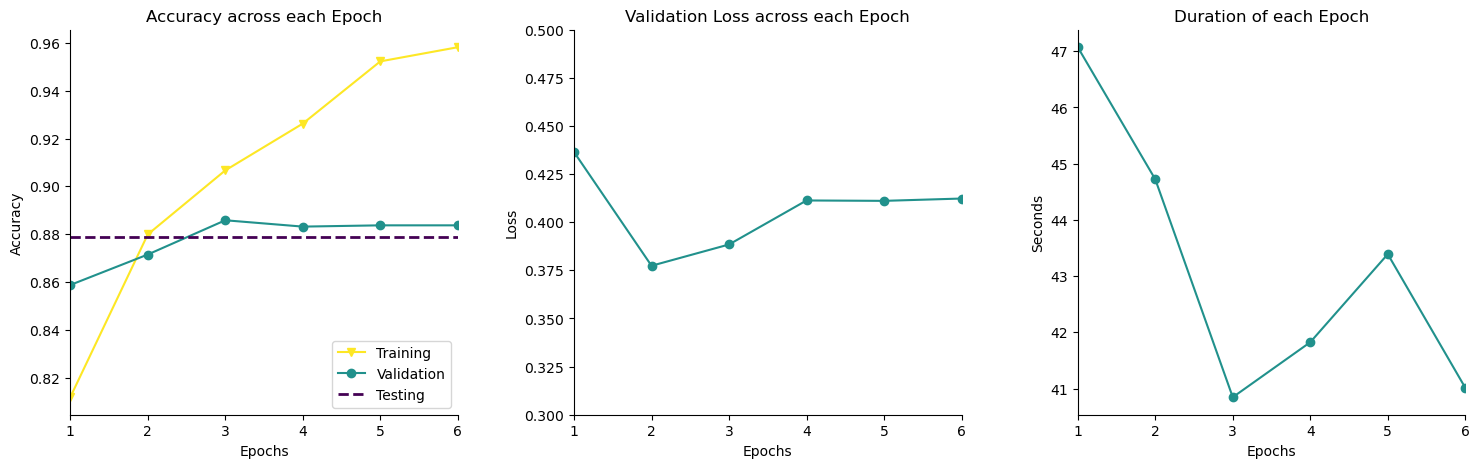

In [8]:
fig = plt.figure(figsize=(18, 5))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
cmap = matplotlib.colormaps.get_cmap('viridis')
colours = cmap(linspace(0, 1, 3))

if len(validation_scores) < EPOCHS:
    end = len(validation_scores)
else:
    end = EPOCHS

plt.subplot(1, 3, 1)
if display_training: 
    training_length = len(training_scores)
    training_space = linspace(0, training_length - 1, end)
    interpolation = interp(training_space, range(training_length), training_scores).tolist()
    plt.plot(range(1, end + 1), interpolation, color=colours[2], marker='v', label='Training')
plt.plot(range(1, end + 1), validation_scores, color=colours[1], marker='o', label='Validation')
plt.axhline(y=test_accuracy, color=colours[0], linestyle='--', linewidth=2, label='Testing')
plt.title('Accuracy across each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(1, end)
plt.legend(loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(range(1, end + 1), validation_losses, color=colours[1], marker='o')
plt.title('Validation Loss across each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(1, end)
plt.ylim(0.3, 0.5)

plt.subplot(1, 3, 3)
plt.plot(range(1, end + 1), epoch_durations, color=colours[1], marker='o')
plt.title('Duration of each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Seconds')
plt.xlim(1, end)

plt.subplots_adjust(wspace=0.3)
plt.show()

In [9]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()
    
model = model.to('cpu')

In [10]:
message = input('Enter text to classify: ')

normalise = lambda x: x.lower().strip('!()}{[]\'"`,.^-_+=/<>:;@#~|¬').replace('&', 'and').replace('fuck', '****').replace('shit', "****").replace('colour', 'color').replace('centre', 'center').replace('favourite', 'favorite').replace('theatre', 'theater').replace(' ?', '?').replace('* * * *', '****').replace('* * *', '***').replace('* *', '**')

label = lambda x: 'hate' if x == 2 else 'maybe hate' if x == 1 else 'not hate' if x == 0 else 'classification error'

print('"' + message + '" is {}'.format(label(predict(normalise(message), text_pipeline))))

"I hate people who are different" is maybe hate
